In [6]:
from sklearn.ensemble import AdaBoostClassifier
#from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
#from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp


In [7]:
def auROCplot():
    ### auROC ###
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    # plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')


    plt.savefig('cv_AuROC.png', dpi=100)
    plt.show()
    ### --- ###

In [17]:
def runAll(X, y):
    Names = []
    Classifiers = []
    estimators = {
              "XGBoost" : XGBClassifier(),
              "AdaBoost" : AdaBoostClassifier(n_estimators=100, random_state=0),
              #"LightGBM": LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1),
              #"ET": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
              "GB" : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
              "MLP" : MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=1, max_iter=1000, learning_rate='constant', learning_rate_init=0.001),
              "Random Forest" : RandomForestClassifier(bootstrap=True,
            criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=False,
            random_state=0,
            verbose=0, warm_start=False)
}
    
    for key, value in estimators.items():
        Names.append(key)
        Classifiers.append(value)


Results = []  # compare algorithms
from sklearn.metrics import accuracy_score, \
        confusion_matrix, \
        roc_auc_score,\
        average_precision_score,\
        roc_curve, f1_score, recall_score, matthews_corrcoef, auc


# Step 05 : Spliting with 10-FCV :
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=10, shuffle=True)


for classifier, name in zip(Classifiers, Names):


        accuray = []
        auROC = []
        avePrecision = []
        F1_Score = []
        AUC = []
        MCC = []
        Recall = []


        mean_TPR = 0.0
        mean_FPR = np.linspace(0, 1, 100)


        CM = np.array([
            [0, 0],
            [0, 0],
        ], dtype=int)


        print(classifier.__class__.__name__)


        model = classifier
        for (train_index, test_index) in cv.split(X, y):


            X_train = X[train_index]
            X_test = X[test_index]


            y_train = y[train_index]
            y_test = y[test_index]


            model.fit(X_train, y_train)

# Calculate ROC Curve and Area the Curve
            y_proba = model.predict_proba(X_test)[:, 1]
            FPR, TPR, _ = roc_curve(y_test, y_proba)
            mean_TPR += np.interp(mean_FPR, FPR, TPR)
            mean_TPR[0] = 0.0
            roc_auc = auc(FPR, TPR)
            ##########################################
            # print(FPR)
            # print(TPR)
            ##########################################


            y_artificial = model.predict(X_test)


            auROC.append(roc_auc_score(y_test, y_proba))


            accuray.append(accuracy_score(y_pred=y_artificial, y_true=y_test))
            avePrecision.append(average_precision_score(y_test, y_proba)) # auPR
            F1_Score.append(f1_score(y_true=y_test, y_pred=y_artificial))
            MCC.append(matthews_corrcoef(y_true=y_test, y_pred=y_artificial))
            Recall.append(recall_score(y_true=y_test, y_pred=y_artificial))
            AUC.append(roc_auc)


            CM += confusion_matrix(y_pred=y_artificial, y_true=y_test)


        accuray = [_*100.0 for _ in accuray]
        Results.append(accuray)


        mean_TPR /= cv.get_n_splits(X, y)
        mean_TPR[-1] = 1.0
        mean_auc = auc(mean_FPR, mean_TPR)
        plt.plot(
            mean_FPR,
            mean_TPR,
            linestyle='-',
            label='{} ({:0.3f})'.format(name, mean_auc), lw=2.0)


        print('Accuracy: {0:.4f} %'.format(np.mean(accuray)))
        # print('auROC: {0:.6f}'.format(np.mean(auROC)))
        print('auROC: {0:.6f}'.format(mean_auc))
        print('auPR: {0:.4f}'.format(np.mean(avePrecision))) # average_Precision
        print('F1-score: {0:.4f}'.format(np.mean(F1_Score)))
        print('MCC: {0:.4f}'.format(np.mean(MCC)))
        # print('average_AUC:', np.mean(AUC))
        # tn, fp, fn, tp = CM.ravel()
        TN, FP, FN, TP = CM.ravel()
        print('Recall: {0:.4f}'.format( np.mean(Recall)) )
        # print('AUC: {0:.4f}'.format( np.mean(AUC)) )
        print('Sensitivity (+): {0:.4f} %'.format( float( (TP) / (TP + FN) )*100.0 ))
        print('Specificity (-): {0:.4f} %'.format( float( (TN) / (TN + FP) )*100.0 ))
        print('Confusion Matrix:')
        print(CM)


        print('_______________________________________')


    ### auROC Curve ###
    auROCplot()


    
runAll(X_train_res, y_train_res)

NameError: name 'Classifiers' is not defined

In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
#from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
#from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
#from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score, auc
# from rotation_forest import RotationForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, roc_auc_score
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from collections import defaultdict


Automatically created module for IPython interactive environment


In [3]:
from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.keras import utils as np_utils
from keras.datasets import mnist

npzfile = np.load('knn_features_007_K-375.npz', allow_pickle=True)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
X_test = npzfile['arr_2']
y_test = npzfile['arr_3']

#X_train, y_train, X_test, y_test = keras.datasets.mnist.load_data(path="knn_features_007_K-375.npz")

# iris = datasets.load_iris()
# X = iris.data
# y = iris.target


# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

NameError: name 'y' is not defined

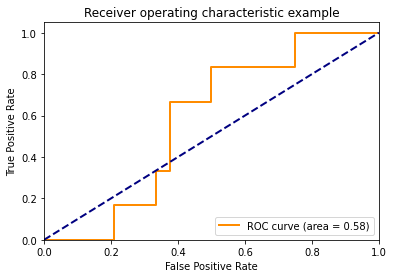

In [50]:
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()